# Goal: Understand the Lunar Crater dataset (LROC) to design the optimal CNN architecture.

## 1. Imports & Setup

In [1]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#from tqdm import tqdm  # Progress bar

# Configure plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2. File config

In [2]:
# UPDATE THIS PATH to your actual dataset location
# Expected structure: data/train/fresh_crater, data/train/old_crater, etc.
DATASET_PATH = "/home/santanu/code/VMontejo/lunar-crater-age-classifier/raw_data/train"

# Define your class names exactly as they appear in folders
CLASSES = ["ejecta", "none", "oldcrater"]

## 3. Class Distribution

Found 358 images in class: ejecta
Found 2656 images in class: none
Found 594 images in class: oldcrater


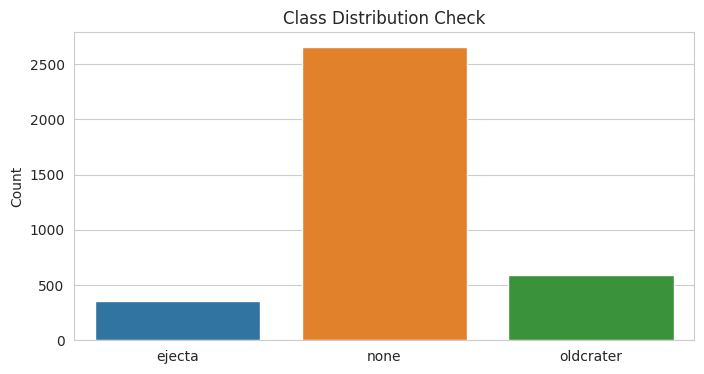

In [3]:
def count_images(base_path, class_names):
    counts = {}
    file_paths = []

    for c in class_names:
        # Construct path: data/train/fresh_crater/*
        path = os.path.join(base_path, c, "*")
        files = glob(path)

        # Filter only images
        images = [f for f in files if f.lower().endswith(('.jpg'))]

        counts[c] = len(images)
        file_paths.extend(images)
        print(f"Found {len(images)} images in class: {c}")

    return counts, file_paths

# Run the function
class_counts, all_files = count_images(DATASET_PATH, CLASSES)

# Visualize
plt.figure(figsize=(8, 4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), hue=list(class_counts.keys()))
plt.title("Class Distribution Check")
plt.ylabel("Count")
plt.show()


## 3. Calculate Dataset Mean & Std

In [17]:
# ...existing code...
def calculate_dataset_stats_full(file_list):
    print(f"Processing {len(file_list)} images for pixel statistics...")

    pixel_values = []

    for img_path in file_list:
        # Load as Grayscale (0 flag)
        img = cv2.imread(img_path, 0)
        if img is not None:
            pixel_values.append(img.flatten())

    if not pixel_values:
        raise ValueError("No valid images loaded. Check file paths and extensions.")

    # Flatten everything into one massive array of pixels
    all_pixels = np.concatenate(pixel_values)

    mean_val = np.mean(all_pixels)
    std_val = np.std(all_pixels)

    return mean_val, std_val, all_pixels

# Run calculation over the whole dataset
pop_mean, pop_std, all_pixels_data = calculate_dataset_stats_full(all_files)

print(f"\n✅ DATASET MEAN: {pop_mean:.4f}")
print(f"✅ DATASET STD: {pop_std:.4f}")
print("Save these numbers! You will use them in your Preprocessing pipeline.")
# ...existing code...

Processing 3608 images for pixel statistics...

✅ DATASET MEAN: 85.3350
✅ DATASET STD: 40.4752
Save these numbers! You will use them in your Preprocessing pipeline.


### 3.1 Calculate and plot histogram of pixel intensities for eachdata set class

In [5]:
def collect_pixels_gray(dir_path):
    """Return a single 1D array of grayscale pixels for all .jpg images in dir_path."""
    pixels = []
    for img_name in os.listdir(dir_path):
        img_path = dir_path / img_name
        if img_path.suffix.lower() in ['.jpg']:  # adjust if you have .png/.jpeg
            img = Image.open(img_path).convert('L')
            arr = np.array(img)
            pixels.append(arr.flatten())
    if not pixels:
        return np.array([], dtype=np.uint8)
    return np.concatenate(pixels)

In [6]:
from pathlib import Path
from PIL import Image

# Compute per-class pixel arrays
class_pixels = {}
for class_name in CLASSES:
	class_path = Path(os.path.join(DATASET_PATH, class_name))
	class_pixels[class_name] = collect_pixels_gray(class_path)

In [7]:
# Print per-class stats
for name, px in class_pixels.items():
    if px.size == 0:
        print(f"{name}: no pixels found")
        continue
    mean = np.mean(px)
    std = np.std(px)
    print(f"{name}: mean={mean:.4f}, std={std:.4f}, count={px.size}")

ejecta: mean=80.5591, std=36.1721, count=18447382
none: mean=86.5891, std=41.0062, count=136861024
oldcrater: mean=82.6060, std=40.1912, count=30608226


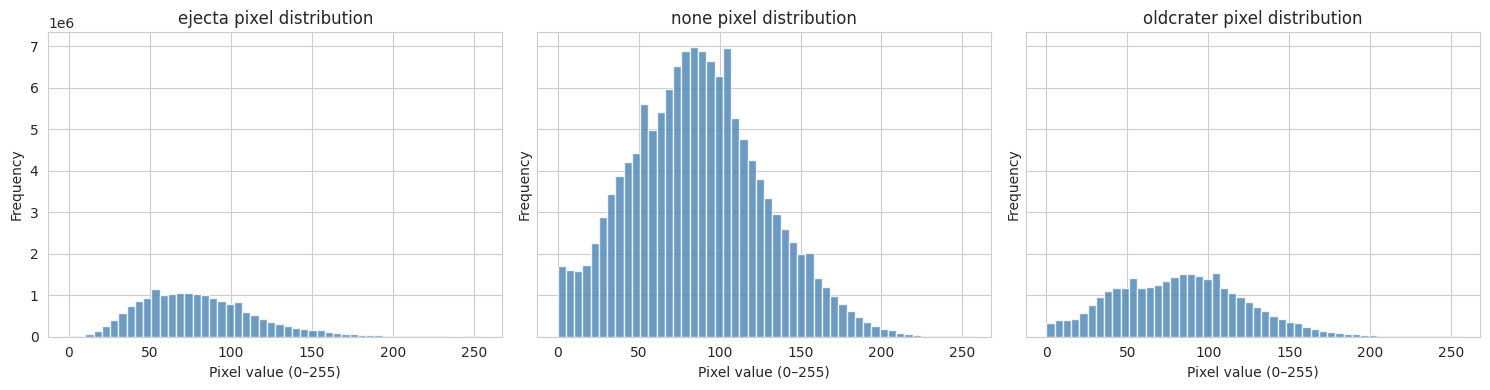

In [10]:
# Plot histograms as subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
bins = 50  # adjust as needed
for ax, (name, px) in zip(axes, class_pixels.items()):
    if px.size == 0:
        ax.set_title(f"{name} (no data)")
        ax.axis('off')
        continue
    ax.hist(px, bins=bins, color='steelblue', alpha=0.8)
    ax.set_title(f"{name} pixel distribution")
    ax.set_xlabel("Pixel value (0–255)")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

### 4. Visualizing Preprocessing Possibilities

In [ ]:

def visualize_preprocessing(file_list, mean_val, std_val):
    # Pick a random image
    img_path = np.random.choice(file_list)
    img = cv2.imread(img_path, 0)

    if img is None:
        return

    img_f = img.astype(np.float32)

    # --- 1. Min-Max Normalization (0 to 1) ---
    norm_img = img_f / 255.0

    # --- 2. Standardization (Z-Score) ---
    # (Pixel - Mean) / Std using dataset stats
    if std_val == 0:
        std_img = img_f - mean_val
    else:
        std_img = (img_f - mean_val) / std_val

    # For visualization: rescale standardized image to 0–1
    std_vis = std_img.copy()
    std_vis_min, std_vis_max = std_vis.min(), std_vis.max()
    if std_vis_max > std_vis_min:
        std_vis = (std_vis - std_vis_min) / (std_vis_max - std_vis_min)
    else:
        std_vis = np.zeros_like(std_vis)

    # --- 3. CLAHE (Contrast Enhancement) ---
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img)  # CLAHE expects uint8

    # --- 4. Canny Edge Detection ---
    edges = cv2.Canny(img, 100, 200)

    # Plotting
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Original (Raw)")

    axes[1].imshow(norm_img, cmap='gray', vmin=0, vmax=1)
    axes[1].set_title("Min-Max (0–1)")

    axes[2].imshow(std_vis, cmap='gray', vmin=0, vmax=1)
    axes[2].set_title(f"Standardized (Z-score)\nμ={mean_val:.1f}, σ={std_val:.1f}")

    axes[3].imshow(clahe_img, cmap='gray')
    axes[3].set_title("CLAHE (Enhanced Contrast)")

    axes[4].imshow(edges, cmap='gray')
    axes[4].set_title("Canny Edges")

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


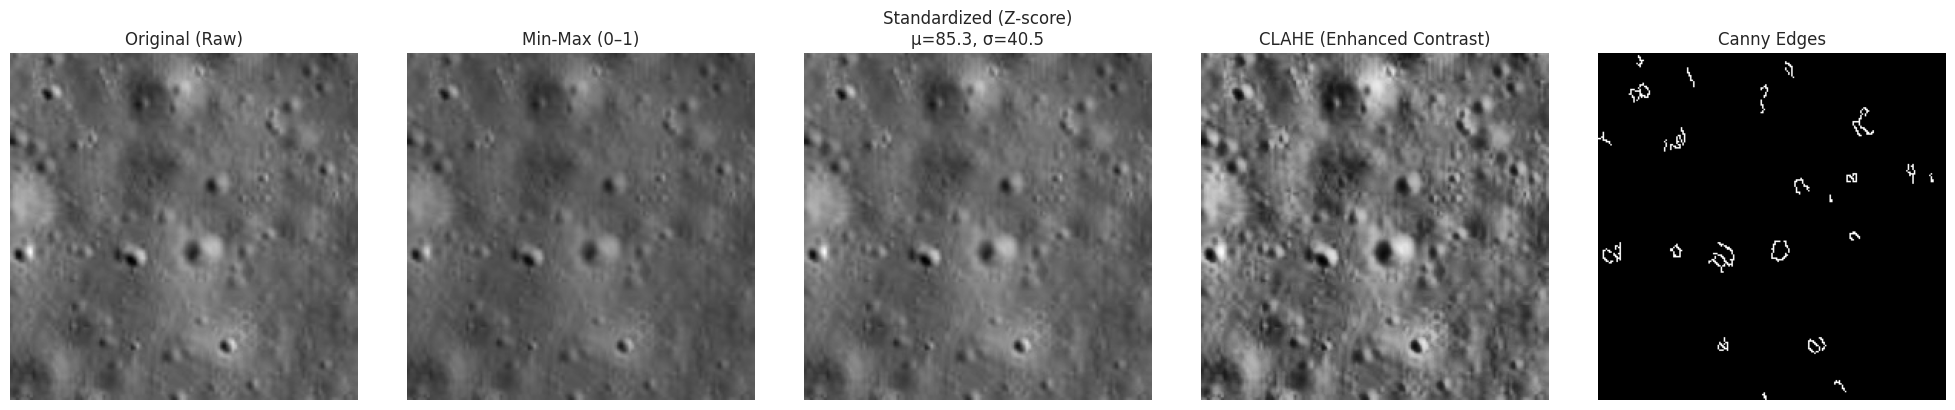

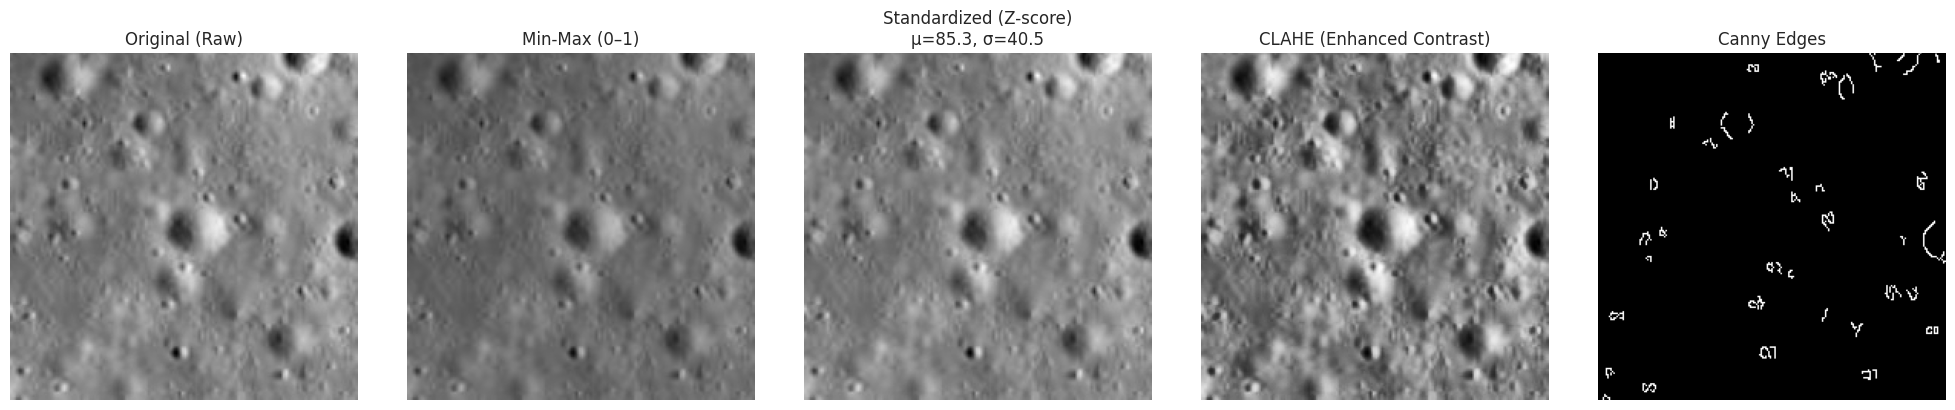

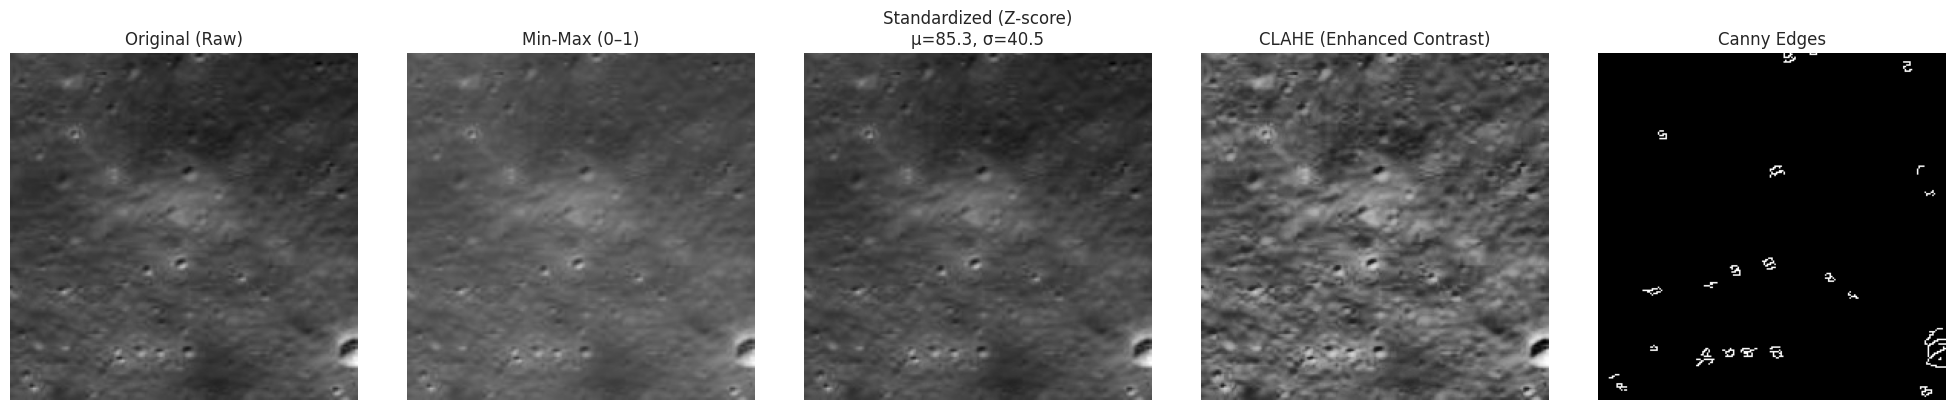

In [22]:
for _ in range(3):
    visualize_preprocessing(all_files, pop_mean, pop_std)
